In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [20]:
# Load the data
df = pd.read_csv('../data/4_sp_songs.csv')

# Select numeric features for clustering
numeric_features = [
    'popularity',
    'album_popularity'
]

# Remove rows with empty genres
df = df[df['genres'].str.len() > 2]  # Remove rows with empty lists '[]'

# Convert genres string to list and create dummies
df['genres'] = df['genres'].apply(eval)  # Convert string representation to actual list
genres_dummies = pd.get_dummies(df['genres'].explode()).groupby(level=0).max()

# Convert isHot to numeric
df['isHot'] = df['isHot'].astype(int)

# Combine numeric features with genre dummies and isHot
features = df[numeric_features].join([genres_dummies, df['isHot']])

# Scale all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
X_scaled_df = pd.DataFrame(X_scaled, columns=features.columns)

with open('../scaler/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [23]:
# 1. KMeans Elbow Method
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

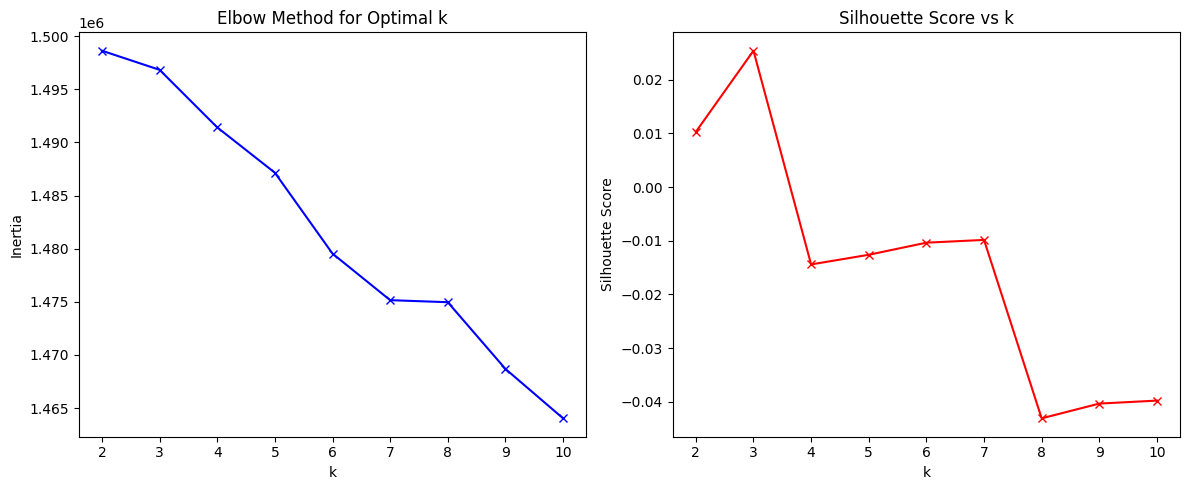

Optimal number of clusters based on silhouette score: 3


In [24]:
# Plot Elbow Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.tight_layout()
plt.show()

# Get optimal k from silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

# 2. Train KMeans with optimal k
best_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = best_kmeans.fit_predict(X_scaled)

# save kmeans model to pickle
with open('../models/kmeans.pkl', 'wb') as f:
    pickle.dump(best_kmeans, f)

In [22]:
# 3. Try DBSCAN with different parameters
eps_range = [0.3, 0.5, 0.7, 1.0]
min_samples_range = [5, 10, 15, 20]
dbscan_scores = []

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        # Only calculate silhouette score if more than one cluster is found
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            score = silhouette_score(X_scaled, labels)
            dbscan_scores.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'silhouette': score
            })

# Find best DBSCAN parameters
dbscan_results = pd.DataFrame(dbscan_scores)
best_dbscan_params = dbscan_results.loc[dbscan_results['silhouette'].idxmax()]
print("\nBest DBSCAN parameters:")
print(best_dbscan_params)

# Train final DBSCAN with best parameters
best_dbscan = DBSCAN(
    eps=best_dbscan_params['eps'], 
    min_samples=int(best_dbscan_params['min_samples'])
)
dbscan_labels = best_dbscan.fit_predict(X_scaled)

# Compare KMeans and DBSCAN results
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
dbscan_silhouette = silhouette_score(X_scaled, dbscan_labels)

print("\nClustering Performance Comparison:")
print(f"KMeans Silhouette Score: {kmeans_silhouette:.3f}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.3f}")

# Choose best performing algorithm and save results
if kmeans_silhouette > dbscan_silhouette:
    print("\nKMeans performed better - using KMeans clusters")
    final_labels = kmeans_labels
    algorithm = 'KMeans'
else:
    print("\nDBSCAN performed better - using DBSCAN clusters")
    final_labels = dbscan_labels
    algorithm = 'DBSCAN'

# Add cluster labels to original dataframe
df['cluster'] = final_labels

# Save clustered dataset
output_path = '../data/5_clustered_dataset.csv'
df.to_csv(output_path, index=False)
print(f"\nSaved clustered dataset to {output_path}")

# save final labels to pickle
with open('../models/dbscan.pkl', 'wb') as f:
    pickle.dump(best_dbscan, f)


Best DBSCAN parameters:
eps             1.000000
min_samples     5.000000
n_clusters     14.000000
silhouette     -0.241487
Name: 4, dtype: float64

Clustering Performance Comparison:
KMeans Silhouette Score: 0.025
DBSCAN Silhouette Score: -0.241

KMeans performed better - using KMeans clusters

Saved clustered dataset to ../data/5_clustered_dataset.csv
